In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf

train_path = '/content/drive/MyDrive/mave3ick-tigers/train_synthetic_4000.xlsx'
test_path  = '/content/drive/MyDrive/mave3ick-tigers/test_monthday.xlsx'

In [ ]:
use_cols = [
    "ProductCategory","ProductPrice","Discount","Channel",
    "CustomerAge","Region","PreQuoteVisits","day","month",
    "ConvertedToSale"
]

train_df = pd.read_excel(train_path, usecols=use_cols).copy()
test_df  = pd.read_excel(test_path,  usecols=use_cols).copy()

train_df.head(), test_df.head()

(  ProductCategory  ProductPrice  ConvertedToSale  Discount   Channel  \
 0           Books          45.9                0      0.10  Referral   
 1         Outdoor          95.0                1      0.10       App   
 2          Beauty          56.0                0      0.10       Web   
 3         Outdoor          88.9                1      0.15  Referral   
 4         Outdoor          88.9                1      0.15  Referral   
 
    CustomerAge    Region  PreQuoteVisits       day  month  
 0           35  Illinois               5    Friday  April  
 1           60     Texas               4  Thursday    May  
 2           40   Georgia               4    Friday  April  
 3           30     Texas               3    Sunday  April  
 4           30     Texas               3    Sunday  April  ,
   ProductCategory  ProductPrice  ConvertedToSale  Discount   Channel  \
 0         Apparel         69.80                0      0.10       App   
 1          Beauty         89.00               

In [ ]:
target_col = "ConvertedToSale"

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col].astype(int)

X_test  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col].astype(int)

In [ ]:
#from re import X
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ProductCategory  4000 non-null   object 
 1   ProductPrice     4000 non-null   float64
 2   Discount         4000 non-null   float64
 3   Channel          4000 non-null   object 
 4   CustomerAge      4000 non-null   int64  
 5   Region           4000 non-null   object 
 6   PreQuoteVisits   4000 non-null   int64  
 7   day              4000 non-null   object 
 8   month            4000 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 281.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ProductCategory  1000 non-null   object 
 1   ProductPrice     1000 non-null   float64
 2   Discount         1000 non-null

In [ ]:
y_train

,ConvertedToSale
0,0
1,1
2,0
3,1
4,1
...,...
3995,0
3996,0
3997,0
3998,1


In [ ]:
y_test

,ConvertedToSale
0,0
1,1
2,0
3,0
4,0
...,...
995,0
996,0
997,0
998,0


In [ ]:
# Explicit column lists
cat_cols = ["ProductCategory","Channel","Region","day","month"]
num_cols = ["ProductPrice","Discount","CustomerAge","PreQuoteVisits"]

# Pipelines
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # if this errors, change to sparse=False
])

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])

X_train_np = preprocess.fit_transform(X_train)
X_test_np  = preprocess.transform(X_test)

X_train_np.shape, X_test_np.shape

((4000, 49), (1000, 49))

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = dict(zip(classes, weights))
class_weight

{np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}

In [ ]:
input_dim = X_train_np.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc"),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall"),
             "accuracy"]
)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=5, restore_best_weights=True
)

history = model.fit(
    X_train_np, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6122 - auc: 0.6522 - loss: 0.6606 - precision: 0.6169 - recall: 0.5784 - val_accuracy: 0.8250 - val_auc: 0.9050 - val_loss: 0.5143 - val_precision: 0.8262 - val_recall: 0.8382
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7915 - auc: 0.8694 - loss: 0.4962 - precision: 0.7810 - recall: 0.8036 - val_accuracy: 0.9000 - val_auc: 0.9576 - val_loss: 0.3262 - val_precision: 0.8795 - val_recall: 0.9348
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8917 - auc: 0.9549 - loss: 0.3123 - precision: 0.8859 - recall: 0.9010 - val_accuracy: 0.9538 - val_auc: 0.9884 - val_loss: 0.1947 - val_precision: 0.9415 - val_recall: 0.9710
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9322 - auc: 0.9817 - loss: 0.2054 - precision: 0.9240 - recall: 0.9408 - val_accuracy: 0.9862 - val_auc: 0.9961 - val_loss: 0.1115 - val_precision: 0.9741 - val_recall: 1.0000
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

# Default 0.5
y_proba = model.predict(X_test_np).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy: 0.407
ROC AUC: 0.41424479166666667

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.40      0.57       960
           1       0.03      0.47      0.06        40

    accuracy                           0.41      1000
   macro avg       0.49      0.44      0.31      1000
weighted avg       0.91      0.41      0.55      1000


Confusion Matrix:
 [[388 572]
 [ 21  19]]


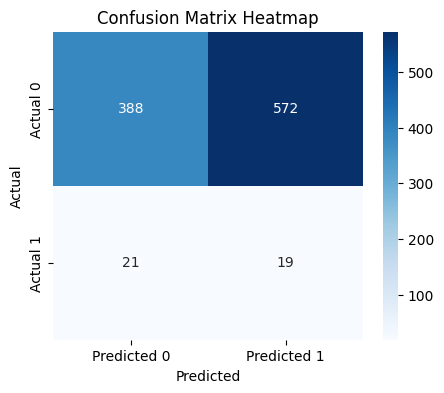

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
# (Optional) choose threshold maximizing F1
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1 = 2*(prec*rec)/(prec+rec+1e-12)
best_idx = f1[:-1].argmax()
best_thr = thr[best_idx]

y_pred_best = (y_proba >= best_thr).astype(int)
print("Best threshold:", best_thr)
print("\nClassification Report @ best thr:\n", classification_report(y_test, y_pred_best))
print("\nConfusion Matrix @ best thr:\n", confusion_matrix(y_test, y_pred_best))


Best threshold: 0.0001281847

Classification Report @ best thr:
               precision    recall  f1-score   support

           0       1.00      0.02      0.04       960
           1       0.04      1.00      0.08        40

    accuracy                           0.06      1000
   macro avg       0.52      0.51      0.06      1000
weighted avg       0.96      0.06      0.04      1000


Confusion Matrix @ best thr:
 [[ 21 939]
 [  0  40]]


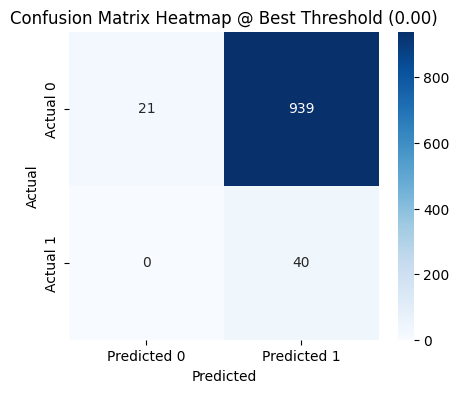

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for best threshold
cm_best = confusion_matrix(y_test, y_pred_best)

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix Heatmap @ Best Threshold ({best_thr:.2f})')
plt.show()